In [26]:
elastic_rods_dir = '../../../elastic_rods/python/'
weaving_dir = '../../../weaving/'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time
from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, set_figure_label_and_limit, Visualization_Setting, plot_objective)

import finite_diff
importlib.reload(finite_diff)
from finite_diff import fd_hessian_test, fd_gradient_test, gradient_convergence_plot, hessian_convergence_plot, hessian_convergence_block_plot

# Reloadable libraries
import fd_weaver_editor
importlib.reload(fd_weaver_editor)
from fd_weaver_editor import get_matvec_error_for_linkage, gradient_convergence_plot, hessian_convergence_plot
# fd_hessian_test, fd_gradient_test, gradient_convergence_plot, hessian_convergence_plot, hessian_convergence_block_plot

import linkage_optimization

In [11]:
rod_length = 0.21162395234664752
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
width *= 1.5
thickness *= 1.5
io = InputOrganizer('sphere_1', thickness, width, weaving_dir)
# io = InputOrganizer('simple_hemoglobin_5_1', thickness, width, weaving_dir)

0.0705413174488825 0.004937892221421775


In [27]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.1
sw = 10

In [28]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [29]:
rw_1, sw_1 = 0.001, 0.01

In [30]:
iterateData = stage_1_optimization(curved_linkage, rw_1, sw_1, curved_linkage_view)

In [31]:
curved_linkage.attraction_weight = 1e-5

In [32]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [33]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.000235428	7.29608e-05	7.29608e-05	1	1
1	0.000235235	0.000118197	0.000118197	1	0
2	0.000235232	1.94354e-08	1.94354e-08	1	0


In [34]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, equilibrium_iter = 200)

In [35]:
optimizer, opt_iterateData, _ = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, [], -5, 3)

rl_regularization_weight 0.1
smoothing_weight 10.0
stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.03162277660168379
stage 2 optimization with attraction weight 1e-05


In [37]:
optimizer, contact_opt_iterateData, _ = contact_optimization(optimizer, curved_linkage, curved_linkage_view, -1, contact_weight = 1e4, normalWeight = 5, torqueWeight = 2)

In [38]:
curr_params = optimizer.params()

### matvec error

In [39]:
get_matvec_error_for_linkage(optimizer.getLinesearchWeaverLinkage())

The hessian vector multiplication error is:  6.843439840341572e-16


In [55]:
def set_weight_for_one_type(optimizer, curr_type):
    optimizer.beta = 0
    optimizer.gamma = 0
    optimizer.smoothing_weight = 0
    optimizer.rl_regularization_weight = 0
    optimizer.contact_force_weight = 0
    if curr_type == linkage_optimization.OptEnergyType.Full:
        optimizer.beta = 5e5
        optimizer.gamma = 1
        optimizer.smoothing_weight = sw
        optimizer.rl_regularization_weight = rw
        optimizer.contact_force_weight = 1e4
    elif curr_type == linkage_optimization.OptEnergyType.Target:
        optimizer.beta = 5e5
    elif curr_type == linkage_optimization.OptEnergyType.Smoothing:
        optimizer.smoothing_weight = sw
    elif curr_type == linkage_optimization.OptEnergyType.Regularization:
        optimizer.rl_regularization_weight = rw
    elif curr_type == linkage_optimization.OptEnergyType.ElasticBase:
        optimizer.gamma = 1
    elif curr_type == linkage_optimization.OptEnergyType.ContactForce:
        optimizer.contact_force_weight = 1e4

### Gradient Finite Difference Error

In [49]:
direction = np.random.uniform(0, 1, optimizer.numParams())
# direction[:linkage.numRestKappaVars()] *= 0
# direction = direction * (la.norm(np.array(optimizer.get_delta_x3d())) / la.norm(direction))

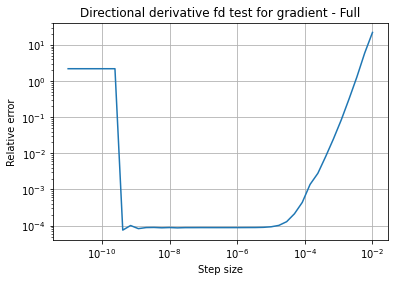

In [50]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.Full)
fd_weaver_editor.gradient_convergence_plot(optimizer, direction, 'Full', linkage_optimization.OptEnergyType.Full)

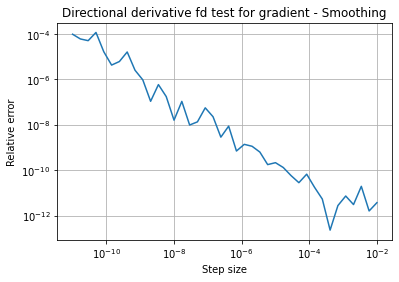

In [51]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.Smoothing)
fd_weaver_editor.gradient_convergence_plot(optimizer, direction, 'Smoothing', linkage_optimization.OptEnergyType.Smoothing)

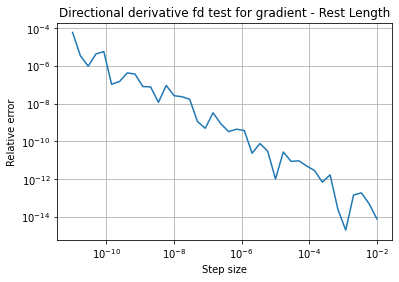

In [52]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.Regularization)
fd_weaver_editor.gradient_convergence_plot(optimizer, direction, 'Rest Length', linkage_optimization.OptEnergyType.Regularization)

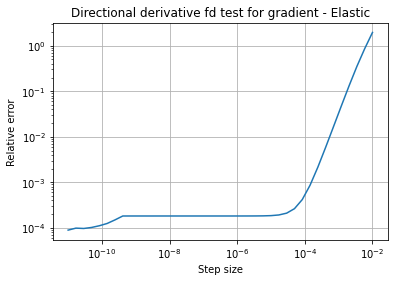

In [56]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.ElasticBase)
gradient_convergence_plot(optimizer, direction, 'Elastic', linkage_optimization.OptEnergyType.ElasticBase)

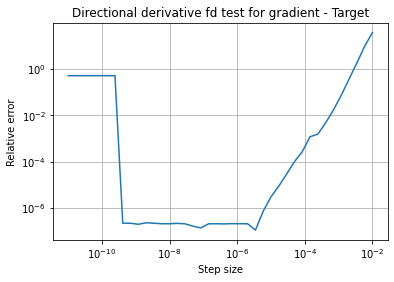

In [57]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.Target)
gradient_convergence_plot(optimizer, direction, 'Target', linkage_optimization.OptEnergyType.Target)

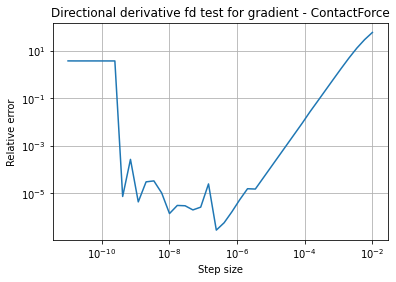

In [58]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.ContactForce)
optimizer.objective.terms[-1].term.torqueWeight = 1
optimizer.objective.terms[-1].term.normalWeight = 0
optimizer.objective.terms[-1].term.tangentialWeight = 0
gradient_convergence_plot(optimizer, direction, 'ContactForce', linkage_optimization.OptEnergyType.ContactForce)

### Hessian Finite Difference Errors

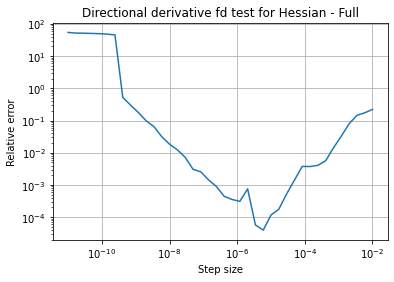

In [63]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.Full)
hessian_convergence_plot(optimizer, direction, 'Full', linkage_optimization.OptEnergyType.Full)

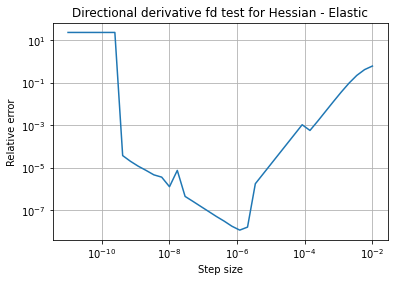

In [64]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.ElasticBase)
error = hessian_convergence_plot(optimizer, direction, 'Elastic', linkage_optimization.OptEnergyType.ElasticBase)

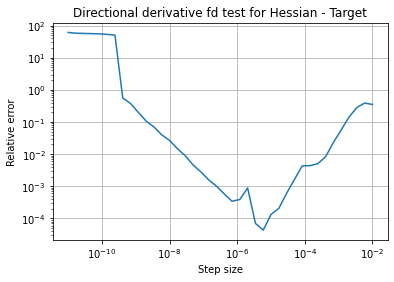

In [65]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.Target)
hessian_convergence_plot(optimizer, direction, 'Target', linkage_optimization.OptEnergyType.Target)

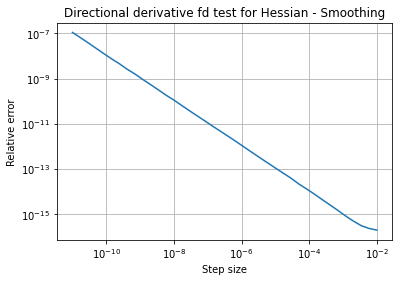

In [66]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.Smoothing)
hessian_convergence_plot(optimizer, direction, 'Smoothing', linkage_optimization.OptEnergyType.Smoothing)

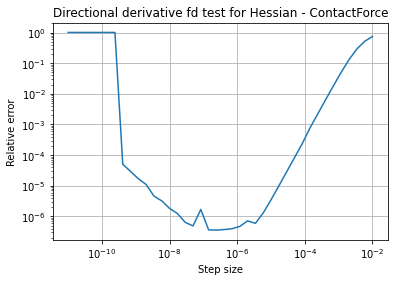

In [67]:
set_weight_for_one_type(optimizer, linkage_optimization.OptEnergyType.ContactForce)
optimizer.objective.terms[-1].term.torqueWeight = 1
optimizer.objective.terms[-1].term.normalWeight = 0
optimizer.objective.terms[-1].term.tangentialWeight = 0
hessian_convergence_plot(optimizer, direction, 'ContactForce', linkage_optimization.OptEnergyType.ContactForce)